In [1]:
%pylab inline
from libanalysis import PhantomAnalysis as pa
from scipy.signal import savgol_filter
from scipy import signal
from scipy.signal import find_peaks

# @customize plot style 
plt.rcParams['axes.grid'] = 'True'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.left'] = True
plt.rcParams['ytick.minor.right'] = True
plt.rcParams['figure.figsize'] = [4.0, 3.0]

plt.rc('font', family='serif')
custom_preamble = {
    "text.usetex": True,
    "text.latex.preamble": [
        r"\usepackage{amsmath}", # for the align enivironment
        ],
    }
plt.rcParams.update(custom_preamble)

Populating the interactive namespace from numpy and matplotlib


In [2]:
H_LIMIT = 0#1e-10


def get_sma(dump):
    udist = dump.units['udist']
    utime = dump.units['utime']
    umass = dump.units['umass']
    uv = udist/utime
    G_cgs = 6.67430e-8
    
    h = dump.xyzh[3]

    pw,ph = dump.ptmass_xyzmh.shape
    
    
    if (ph > 0):
        Mb = dump.ptmass_xyzmh[3][0]
        
        x0 = dump.ptmass_xyzmh[0][0]
        y0 = dump.ptmass_xyzmh[1][0]
        z0 = dump.ptmass_xyzmh[2][0]
        vx0 = dump.ptmass_vxyz[0][0]
        vy0 = dump.ptmass_vxyz[1][0]
        vz0 = dump.ptmass_vxyz[2][0]
    else:
        Mb = 10
        x0 = 0
        y0 = 0
        z0 = 0
        vx0=0
        vy0=0
        vz0=0
    
        
    x = dump.xyzh[0] - x0
    y = dump.xyzh[1] - y0 
    z = dump.xyzh[2] - z0 
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    vx = dump.vxyz[0] - vx0
    vy = dump.vxyz[1] - vy0
    vz = dump.vxyz[2] - vz0
    
    v2 = (vx**2 + vy**2 + vz**2)
    
    u = Mb
    
    return (-u*r/(r*v2-2*u))
    
def get_r(dump):
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    h = dump.xyzh[3]
    pw,ph = dump.ptmass_xyzmh.shape
    
    if (ph > 0):
        x0 = dump.ptmass_xyzmh[0][0]
        y0 = dump.ptmass_xyzmh[1][0]
        z0 = dump.ptmass_xyzmh[2][0]
    else:
        x0 = 0
        y0 = 0
        z0 = 0
    return np.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)

def inter_ep(dump):
    m = dump.massofgas
    
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    ep = np.zeros(x.shape)
    for xx, yy, zz, i in zip(x, y, z, range(len(x))):
        dx = x - xx
        dy = y - yy
        dz = z - zz
        dr = np.sqrt(dx**2 + dy**2 + dz**2)
        p = (1/dr[dr!=0]).sum()
        ep[i] = -p*m
    return ep

def get_E(dump):
    h = dump.xyzh[3]

    pw,ph = dump.ptmass_xyzmh.shape
    
    
    if (ph > 0):
        Mb = dump.ptmass_xyzmh[3][0]
        
        x0 = dump.ptmass_xyzmh[0][0]
        y0 = dump.ptmass_xyzmh[1][0]
        z0 = dump.ptmass_xyzmh[2][0]
        vx0 = dump.ptmass_vxyz[0][0]
        vy0 = dump.ptmass_vxyz[1][0]
        vz0 = dump.ptmass_vxyz[2][0]
    else:
        Mb = 10
        x0 = 0
        y0 = 0
        z0 = 0
        vx0=0
        vy0=0
        vz0=0
    print(x0,y0,z0)
        
    x = dump.xyzh[0] - x0
    y = dump.xyzh[1] - y0 
    z = dump.xyzh[2] - z0 
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    vx = dump.vxyz[0] - vx0
    vy = dump.vxyz[1] - vy0
    vz = dump.vxyz[2] - vz0
    
    v2 = (vx**2 + vy**2 + vz**2)
    return -Mb/r + 0.5*v2

def get_vr(dump):
    pw,ph = dump.ptmass_xyzmh.shape
    
    if (ph > 0):
        Mb = dump.ptmass_xyzmh[3][0]
        
        x0 = dump.ptmass_xyzmh[0][0]
        y0 = dump.ptmass_xyzmh[1][0]
        z0 = dump.ptmass_xyzmh[2][0]
        vx0 = dump.ptmass_vxyz[0][0]
        vy0 = dump.ptmass_vxyz[1][0]
        vz0 = dump.ptmass_vxyz[2][0]
    else:
        Mb = 10
        x0 = 0
        y0 = 0
        z0 = 0
        vx0=0
        vy0=0
        vz0=0
        
    x = dump.xyzh[0] - x0
    y = dump.xyzh[1] - y0 
    z = dump.xyzh[2] - z0 
    
    
    
    vx = dump.vxyz[0] - vx0
    vy = dump.vxyz[1] - vy0
    vz = dump.vxyz[2] - vz0
    
    vr = vx*x + vy*y + vz*z
    return vr
    
def get_ecc(dump,Mb):
    pw,ph = dump.ptmass_xyzmh.shape
    
    if (ph > 0):
        
        x0 = dump.ptmass_xyzmh[0][0]
        y0 = dump.ptmass_xyzmh[1][0]
        z0 = dump.ptmass_xyzmh[2][0]
        vx0 = dump.ptmass_vxyz[0][0]
        vy0 = dump.ptmass_vxyz[1][0]
        vz0 = dump.ptmass_vxyz[2][0]
    else:
        
        x0 = 0
        y0 = 0
        z0 = 0
        vx0=0
        vy0=0
        vz0=0
    
    u = Mb
    
    h = dump.xyzh[3]
    
    x = dump.xyzh[0] - x0
    y = dump.xyzh[1] - y0
    z = dump.xyzh[2] - z0
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    vx = dump.vxyz[0] - vx0
    vy = dump.vxyz[1] - vy0
    vz = dump.vxyz[2] - vz0
    
    v2 = vx**2 + vy**2 + vz**2
    
    dot = x*vx + y*vy + z*vz
    
    rcof = v2/u - 1/r
    
    vcof = dot/u
    
    ex = rcof * x - vcof * vx
    
    ey = rcof * y - vcof * vy
    
    ez = rcof * z - vcof * vz
    
    e = np.sqrt(ex**2 + ey**2 + ez**2)
    
    return e

def get_bound(dump):
    pw,ph = dump.ptmass_xyzmh.shape
    
    if ph > 0:
        Mb = dump.ptmass_xyzmh[3][0]
    else:
        Mb=10
    return get_E(dump, Mb) < 0

def get_bound_particle(dump):
    active = dump.xyzh[3] > H_LIMIT
    a = get_sma(dump)
    
    return (a>0)&active

def get_critical_e(dump):
    pw,ph = dump.ptmass_xyzmh.shape
    
    if (ph > 0):
        Mb = dump.ptmass_xyzmh[3][0]
    else:
        Mb = 10
        
    active = dump.xyzh[3] > 0
    
    e = get_ecc(dump, Mb)
    
    t = dump.time
    
    xbins = 'auto'
    
    emin = 0
    emax = 2

    num, bins = np.histogram(e[active&(emin<=e)&(e<=emax)],bins=xbins,density=True)
    plt.figure()
    plt.hist(e[active&(emin<=e)&(e<=emax)],'auto')

    cbin = 0.5*(bins[0:-1] + bins[1::])
    
    zero = np.argmin(num)
    
    valley_idx = signal.argrelextrema(num, np.less, order=2)
    valley_idx = valley_idx[0]

    peaks, _ = find_peaks(num, prominence=0.05)
    
    disjoint = 0
   
    if( (len(peaks)>1)):
        peak1 = peaks[0]
        peak2 = peaks[1]
    
        if (peak1 < zero) & (zero < peak2):
            disjoint = zero
        elif len(valley_idx) > 0:
            for v in valley_idx:
                if (peak1 < v)&(v < peak2)&(v>disjoint):
                    disjoint = v
    if disjoint == 0:
        if(t > 150):
            critical_e = cbin[   valley_idx[peaks[0] < valley_idx][0] ]
        else:
            critical_e = 0
    else:
        critical_e = cbin[disjoint]
    
    return min(critical_e,1)


A_SHIFT = 3
TIME_DETECT = 30
          
def get_critical_a(dump, last_a):
    pw,ph = dump.ptmass_xyzmh.shape
    
    if ph > 0:
        Mb = dump.ptmass_xyzmh[3][0]
    else:
        Mb = 10
        
    active = dump.xyzh[3] > H_LIMIT
    
    a = get_sma(dump)
    h = dump.xyzh[3] 
    
    t = dump.time
    
    if t < 10:
        return  0
    
    xbins = 'auto'
    
    amin = 0.5
    amax = 50000
    
    num, bins = np.histogram(np.log10(a[(amin<a)&(a<amax)&(active)]),bins=xbins,density=True)
    
    cbin = 0.5*(bins[0:-1] + bins[1::])
    
    zero = np.argmin(num)
    
    valley_idx = signal.argrelextrema(num, np.less, order=2)
    valley_idx = valley_idx[0]

    peaks, _ = find_peaks(num, prominence=0.05)
    
    disjoint = 0
    
    critical_as = []
    
    for i in range(len(peaks)-1):
        peak1 = peaks[i]
        peak2 = peaks[i+1]
    
        if (peak1 < zero) & (zero < peak2):
            disjoint = zero
        elif len(valley_idx) > 0:
            for v in valley_idx:
                if (peak1 < v)&(v < peak2)&(v>disjoint):
                    disjoint = v
                    
        if disjoint == 0:
            if(t > 150):
                critical_a = 10**cbin[valley_idx[peaks[0] < valley_idx][0]]
            else:
                critical_a = 0
        else:
            critical_a = 10**cbin[disjoint]
     
        critical_as.append(critical_a)
        
    d = 10000
        
    for a_c in critical_as:
        if abs(a_c-last_a) < d:
            critical_a = a_c
            d = abs(a_c-last_a)
            
    if len(critical_as) == 0 or ((d > A_SHIFT)&(t>TIME_DETECT) ):
        critical_a = last_a
        
    
    return critical_a


def get_acc_particle(dump):
    h = dump.xyzh[3]
    return h <= H_LIMIT

def get_disk_particle(dump,last_a):
    active = dump.xyzh[3] > H_LIMIT
    dead = dump.xyzh[3] <= H_LIMIT
    a = get_sma(dump)
    #e = get_ecc(dump, Mb)
    
    ca = get_critical_a(dump,last_a)
    #ce = get_critical_e(dump)
   # print('xxxxxxx:',(active&dead).sum())
    #return active, ca
    return (a<ca)& active & (a>0), ca
    
    
def sssget_cls_disk_particle(dump):
    active = dump.xyzh[3] > H_LIMIT
    dead = dump.xyzh[3] <= H_LIMIT
    a = get_sma(dump)
    #e = get_ecc(dump, Mb)
    
    ca = get_cls_critical_a(dump)
    #ce = get_critical_e(dump)
   # print('xxxxxxx:',(active&dead).sum())
    #return active, ca
    return (a<ca)& active & (a>0)
    
    
def get_fall_particle(dump):
    Mb = dump.ptmass_xyzmh[3][0]
    return get_disk_particle(dump, Mb) | get_acc_particle(dump)
    

In [50]:
prefix = '../code/sink/0.5M/mass/fixed_h_10ms/'
fname = 'tde_00030'
dump = pa(prefix+fname)
print(dump.units)

Unable to load magnetic field, likely the quantity is not stored.
{'udist': 69595000000.0, 'udens': 5.900957678061918, 'umagfd': 376040675.58543974, 'umass': 1.9891e+33, 'utime': 1593.7103639003628}


tde_00000
Unable to load magnetic field, likely the quantity is not stored.
tde_00010
Unable to load magnetic field, likely the quantity is not stored.
tde_00020
Unable to load magnetic field, likely the quantity is not stored.
tde_00030
Unable to load magnetic field, likely the quantity is not stored.
tde_00040
Unable to load magnetic field, likely the quantity is not stored.
tde_00050
Unable to load magnetic field, likely the quantity is not stored.
tde_00060
Unable to load magnetic field, likely the quantity is not stored.
tde_00070
Unable to load magnetic field, likely the quantity is not stored.
tde_00080
Unable to load magnetic field, likely the quantity is not stored.
tde_00090
Unable to load magnetic field, likely the quantity is not stored.
tde_00100
Unable to load magnetic field, likely the quantity is not stored.
tde_00110
Unable to load magnetic field, likely the quantity is not stored.
tde_00120
Unable to load magnetic field, likely the quantity is not stored.
tde_00130
Un

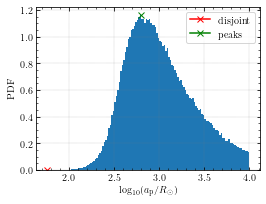

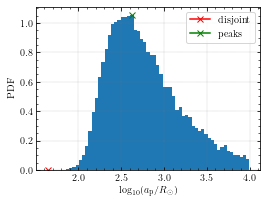

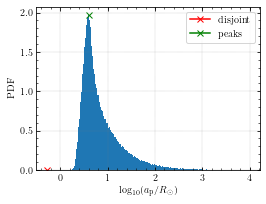

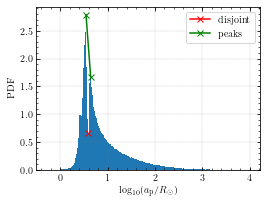

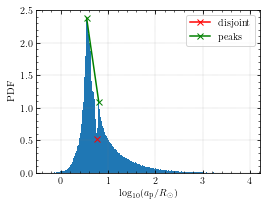

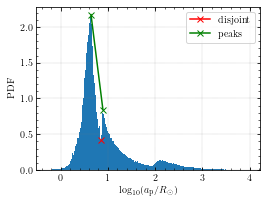

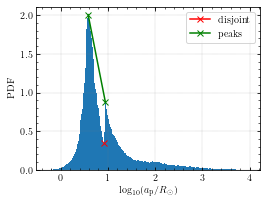

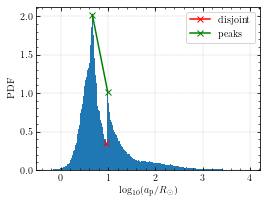

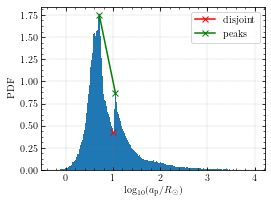

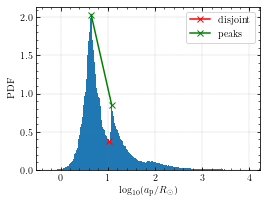

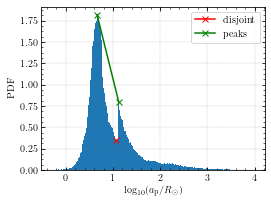

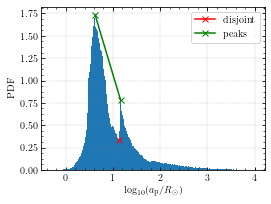

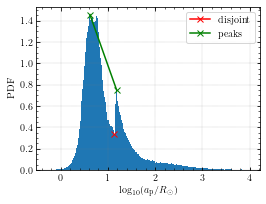

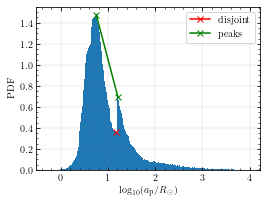

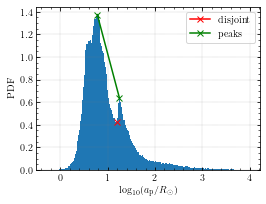

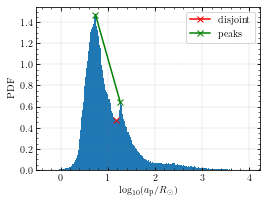

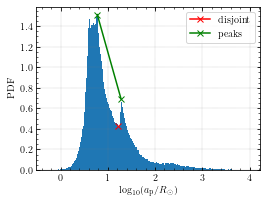

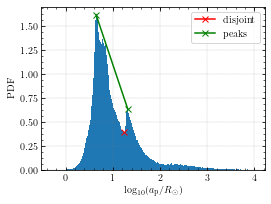

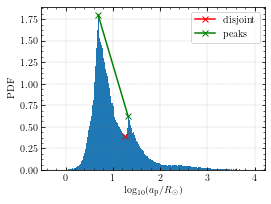

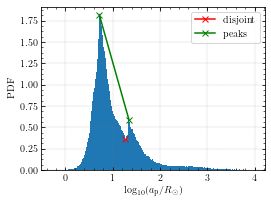

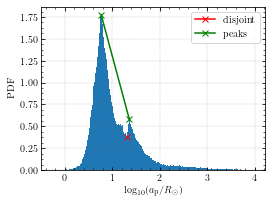

In [140]:
def draw_a(dump, figname):
    Mb = dump.ptmass_xyzmh[3][0]
    #a = #-Mb/2/get_E(dump)
    a = get_sma(dump)
    xbins = 'auto'
    
    amin = 0.5
    amax = 10000
    
    active = dump.xyzh[3] > 0
    
    t = dump.time
    
    num, bins = np.histogram(np.log10(a[(amin<a)&(a<amax)&active]),bins=xbins,density=True)
    
    plt.figure(figsize=(4,3))
    plt.hist(np.log10(a[(amin<a)&(a<amax)]),bins=xbins,density=True)

    cbin = 0.5*(bins[0:-1] + bins[1::])
    
    zero = np.argmin(num)
    
    valley_idx = signal.argrelextrema(num, np.less, order=2)
    valley_idx = valley_idx[0]

    peaks, _ = find_peaks(num, prominence=0.1)
    
    disjoint = 0
    #if ((t>200)&len(peaks) <= 1):
    #    disjoint = -1
    if( (len(peaks)>1)):
        peak1 = peaks[0]
        peak2 = peaks[1]
    
        if (peak1 < zero) & (zero < peak2):
            disjoint = zero
        elif len(valley_idx) > 0:
            for v in valley_idx:
                if (peak1 < v)&(v < peak2)&(v>disjoint):
                    disjoint = v
    
    if disjoint == 0:
        if(t > 150):
            
            critical_a = 10**cbin[   valley_idx[peaks[0] < valley_idx][0] ]
        else:
            critical_a = 0
    else:
        critical_a = 10**cbin[disjoint]
                    
    plt.plot(cbin[disjoint], num[disjoint],color='r',marker='x',label='disjoint')
    plt.plot(cbin[peaks], num[peaks],color='g',marker='x',label='peaks')
    plt.legend()
    plt.xlabel('$\log_{10}(a_{\\rm p}/R_\odot)$')
    plt.ylabel('PDF')
    plt.savefig(figname,dpi=192)
    
    
prefix = '../code/sink/0.5M/mass/fixed_h_10ms/'
idx = np.linspace(0,20,21)

for i in idx:
    fname = 'tde_%05d'% (i*10)
    print(fname)
    dump = pa(prefix+fname)
    draw_a(dump,'figs/dist_a_%05d.png' % i)

In [ ]:
def get_E(dump):
    ut = dump.units['utime']
    ud = dump.units['udist']
    um = dump.units['umass']
    xyzh = dump.xyzh*ud
    
    x = xyzh[0,:]
    y = xyzh[1,:]
    z = xyzh[2,:]

    vxyzu = dump.vxyz*ud/ut
    utherm = dump.utherm*(ud/ut)**2
    self_poten = dump.poten *(ud/ut)**2
    
    mgas = dump.massofgas*um
    
    accreted = xyzh[3,:] < 0
    free = xyzh[3,:] >= 0 
    
    ptvxyz = dump.ptmass_vxyz*ud/ut
    
    mb = dump.ptmass_xyzmh[3]*um

    ein = dump.ptmass_xyzmh[5]*mb*(ud/ut)**2
    
    #print(mgas, (ud/ut)**2)
    ek = 0.5*mgas*((vxyzu[0:3,free]**2).sum(axis=0)).sum() + 0.5*mb*(ptvxyz**2).sum()
   # ep = (poten[free]).sum()*mgas
    eu = (utherm[free]).sum()*mgas
    
    
    bx  = dump.ptmass_xyzmh[0]*ud
    by  = dump.ptmass_xyzmh[1]*ud
    bz  = dump.ptmass_xyzmh[2]*ud
    print(bx,by,bz)
    
    dx = x - bx
    dy = y - by
    dz = z - bz
    r = np.sqrt(dx**2 + dy**2 + dz**2)
    
    G = 6.67428e-8
    ep = ((-G*mb*mgas/r)[free]).sum() + mgas*(self_poten).sum()
    
    #print(eu)
    return float(ek), float(ep), float(eu), float(ein)
    
def energy_check():
    prefix = "../code/local-test/"
    idx = np.linspace(0,30,31)
    Ek = []
    Ep = []
    Eu = []
    Ei = []
    
    for i in idx:
        fname = 'tde_%05d'% i
        dump = pa(prefix+fname)
        ek, ep, eu, ein = get_E(dump)
        print(ek, ep, eu, ein)
        Ek.append(ek)
        Ep.append(ep)
        Eu.append(eu)
        Ei.append(ein)
        
    return np.array(Ek), np.array(Ep), np.array(Eu), np.array(Ei)
        
k,p,u,i = energy_check()

In [6]:
colors = plt.cm.viridis(np.linspace(0,1,3))

def get_classify(dump, a_last):
    disk, a_c = get_disk_particle(dump, a_last)
    #disk =  disk_i #| disk 
    acc = get_acc_particle(dump)
    bound = get_bound_particle(dump) & (~acc) & (~disk)
    rem = (~acc) & (~disk) & (~bound)
    umass = dump.massofgas
    nd = disk.sum()*umass
    na = acc.sum()*umass
    nb = bound.sum()*umass
    nr = rem.sum()*umass
    th_mass = umass*len(disk)
    calc_mass = nd+na+nb+nr
    print(nd, na, nb, nr, nd+na,a_c,th_mass, calc_mass)
    return rem, bound, disk, acc, a_c

def draw_classify(dump, figname, ain):    
    rem, bound, disk, acc, last_a = get_classify(dump,ain)
    plt.figure(figsize=(4,3))
    plt.scatter(dump.xyzh[0][rem], dump.xyzh[1][rem],s=0.1,color='orange',lw=0)
    
    plt.scatter(dump.xyzh[0][bound], dump.xyzh[1][bound],s=0.1,color='green',lw=0)
    
    plt.scatter(dump.xyzh[0][disk], dump.xyzh[1][disk],s=0.1,color='red',lw=0)
    #plt.scatter(dump.xyzh[0][acc], dump.xyzh[1][acc],s=0.01,color='k',lw=0,label='accreted')
    #plt.plot([],[],lw=0,label='t = '+str(int(dump.time*1593.7103639/60)) + ' min' )
    #plt.legend()
    #plt.xlabel('x [$R_\odot$]')
    #plt.ylabel('y [$R_\odot$]')
    plt.xlim([-100,100])
    plt.ylim([-100,100])
    #plt.savefig(figname,dpi=192)
    
    return last_a, disk, acc
    


In [ ]:
prefix = '../code/sink/0.5M/iso-massb/fixed_h_5ms/'
idx = np.linspace(0,20,21)

last_a = 0
for i in idx:
    fname = 'tde_%05d'% (i*10)
    dump = pa(prefix+fname)
    if i ==0:
        disk = dump.xyzh[3] < H_LIMIT
        
    last_a, disk, acc = draw_classify(dump,'figs/classify_%05d.png' % i,last_a)

In [ ]:
def get_Etot(dump, Mb):
    x = dump.xyzh[0]
    y = dump.xyzh[1]
    z = dump.xyzh[2]
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    ep = -Mb/r #+ inter_ep(dump)
    
    vx = dump.vxyz[0]
    vy = dump.vxyz[1]
    vz = dump.vxyz[2]
    
    ek = 0.5*(vx**2 + vy**2 + vz**2)
    
    u = dump.vxyz[3]
    
    return dump.massofgas*(ep+ek) + u

def energy_check(prefix, idx):
    times = []
    E_tot = []
    for i in idx:
        fname = 'tde_%05d'% i
        print(fname)
        dump = pa(prefix+fname)
        times.append(dump.time * dump.units['utime'])
        E_tot.append((get_Etot(dump, 10)).sum())
        
    return np.array(times), np.array(E_tot)

t,E = energy_check('../code/unsoft/1e4/', np.linspace(0,100,101))

In [7]:

A_SHIFT = 3
TIME_DETECT = 30
def get_masses(prefix, idx):
    times =[]
    disk_m=[]
    acc_m =[]
    stream_m = []
    rest_m =[]
    last_a = 0
    for i in idx:
        
        fname = 'tde_%05d'% i
        dump = pa(prefix+fname)
        if i ==0:
            disk = dump.xyzh[3] < H_LIMIT
        
        rem, bound, disk, acc, a_c = get_classify(dump, last_a)
        last_a = a_c
        
        #last_a, disk, acc = draw_classify(dump, 'figs/classify_%05d.png' % i, last_a, disk)
            
        times.append(dump.time * dump.units['utime'])
        
        disk_mass = dump.massofgas * disk.sum()
        disk_m.append(disk_mass)
        
        acc_mass = dump.massofgas * acc.sum()
        acc_m.append(acc_mass)
        
        stream_mass = dump.massofgas * bound.sum()
        stream_m.append(stream_mass)
        
        rest_mass = dump.massofgas * rem.sum()
        rest_m.append(rest_mass)
        
        #disk_p_i, last_a = get_disk_particle(dump,a_in)
        #a_in = last_a
        #disk_p = disk_p | disk_p_i
        #disk_mass = dump.massofgas * disk_p.sum()
        #disk_m.append(disk_mass)
        #acc_mass = dump.massofgas * get_acc_particle(dump).sum()
        #acc_m.append(acc_mass)
        #print(disk_mass,acc_mass,last_a)

    times = np.array(times)
    disk_m = np.array(disk_m)
    acc_m = np.array(acc_m)
    stream_m = np.array(stream_m)
    rest_m = np.array(rest_m)
    return times, disk_m, acc_m, stream_m, rest_m

In [8]:
time_5, disk_5, acc_5, strm_5, rest_5 = get_masses('../code/sink/0.5M/iso-massb/fixed_h_5ms/', np.linspace(0,200,201))

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.4958386152286564, 0.5041613847713435, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.37875535432809404, 0.6212446456719058, 0.0, 0, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.1582732548259758, 0.8417267451740241, 0.0, 0, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.1073053251271073, 0.8926946748728927, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.10892

(0.15111461826790293, 0.014307506899831825, 0.5967021440751296, 0.23787573075713567, 0.16542212516773475, 2.55401880606255, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.17922178881924491, 0.02625354269496786, 0.5709349589525928, 0.22358970953319438, 0.20547533151421277, 2.7516471424080815, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.19520517843853827, 0.04163338014606353, 0.552482669849151, 0.21067877156624715, 0.2368385585846018, 2.8673036126125293, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.20226224634694678, 0.058126566256941334, 0.5402612267539636, 0.19934996064214824, 0.26038881260388813, 3.0689247931790797, 0.99999999999

(0.11596795899751743, 0.32211520619412504, 0.4328836316261336, 0.12903320318222392, 0.4380831651916425, 5.0263804886671135, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.11468272493061102, 0.325990440827472, 0.4310573491754383, 0.12826948506647862, 0.440673165758083, 5.309948461319347, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.11319435356437596, 0.32989497410976054, 0.4293580275368235, 0.12755264478903997, 0.4430893276741365, 5.639313459551326, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.11159074084563712, 0.3335709779303043, 0.42774660184503355, 0.12709167937902488, 0.44516171877594146, 4.832016245863847, 0.9999999999999999, 0.9999999999999

(0.08999373008912648, 0.3908205379622594, 0.39821551695512813, 0.12097021499348592, 0.4808142680513859, 7.901953204528429, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0893179079202061, 0.3922190601384068, 0.39768423478765313, 0.12077879715373391, 0.4815369680586129, 8.0707463629042, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0886987298059062, 0.393584377179087, 0.3970357580244116, 0.12068113499059513, 0.4822831069849932, 8.303417405684142, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.08800923493414639, 0.39484031259705177, 0.3965454939654549, 0.12060495850334688, 0.48284954753119813, 8.267077283650625, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely 

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.07586592156947002, 0.4170877533600667, 0.3887559598335055, 0.1182903652369577, 0.49295367492953673, 9.301913155509286, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.07553582345806094, 0.4176170822842789, 0.3886250925348995, 0.11822200172276055, 0.49315290574233983, 9.296255037181282, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.07525260318495845, 0.41813859823544003, 0.3884356279384103, 0.11817317064119116, 0.4933912014203985, 9.444662557316882, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.07488344020829385

(0.06823069365527991, 0.4285200861770927, 0.3837087792424932, 0.11954044092513413, 0.4967507798323726, 9.735495414670291, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.06803536932900234, 0.42874470915231194, 0.38226533247130196, 0.12095458904738372, 0.4967800784813143, 9.584743834172123, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.06769941148780492, 0.4290044905062611, 0.38129457056970245, 0.12200152743623148, 0.496703901994066, 9.099842179703797, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.06732243553808921, 0.4292369264545314, 0.3810328359724905, 0.12240780203488882, 0.4965593619926206, 8.28561249538161, 0.9999999999999999, 1.0)
Unable to load poten, likel

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.057146038139027945, 0.4372881951836927, 0.3144135680090005, 0.19115219866827873, 0.4944342333227207, 2.715440598282521, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.11856772578027185, 0.4378546357298977, 0.25588854012645296, 0.18768909836337747, 0.5564223615101695, 4.642900469350803, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.16282040514171756, 0.4384640476278837, 0.2138156802462649, 0.1848998669841338, 0.6012844527696013, 5.763579643100225, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.16795352843629202, 0.4390754127691325, 0.2103623

In [9]:
time_10, disk_10, acc_10, strm_10, rest_10 = get_masses('../code/sink/0.5M/iso-massb/fixed_h_10ms/', np.linspace(0,200,201))

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.49438930872767683, 0.505610691272323, 0.0, 0, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.40631171027933327, 0.5936882897206667, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.2622483001900506, 0.7377516998099494, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.20980371858452365, 0.7901962814154763, 0.0, 0, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.2005

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.26466446210610406, 0.020151610742056646, 0.29321306563483335, 0.42197086151700586, 0.2848160728481607, 4.643059027713833, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.26687358023630336, 0.025239809441587283, 0.2817944055206467, 0.42609220480146254, 0.29211338967789063, 4.749112222090845, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2682896816018157, 0.03039832489857784, 0.27062966703062097, 0.4306823264689854, 0.29868800650039357, 4.726015371754955, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2701276835120876, 0.03539472116475802, 0.2584023642056452

(0.24997607277003098, 0.1499934566350697, 0.1471964122827749, 0.4528340583121243, 0.39996952940510067, 7.790043430712942, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2487455295144823, 0.1530268434221603, 0.14756948174596507, 0.45065814531739223, 0.4017723729366426, 7.716209999013652, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2475247524752475, 0.15596842777590048, 0.14763003228711113, 0.4488767874617408, 0.403493180251148, 7.52985682060744, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.24637624543673542, 0.1588084434799763, 0.14731165363527868, 0.4475036574480095, 0.4051846889167117, 7.396231678304792, 0.9999999999999999, 1.0)
Unable to load 

(0.22182593086690794, 0.21567126134590178, 0.11023519002127082, 0.4522676177659194, 0.4374971922128097, 8.832422665126888, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2212985551859585, 0.21694868243975707, 0.11049497137521998, 0.4512577909990644, 0.4382472376257156, 8.272239382733265, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.22086102869509674, 0.218177272452043, 0.10954374190624822, 0.45141795694661196, 0.4390383011471397, 9.797499751841292, 0.9999999999999999, 0.9999999999999998)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.22046842679927883, 0.21932968597708064, 0.1077467581044946, 0.45245512911914587, 0.4397981127763595, 10.020095122891462, 0.9999999999999999, 1.0)
Unable to 

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.21107332670532786, 0.2446749705548578, 0.08248546298701678, 0.4617662397527975, 0.4557482972601856, 12.020309258658006, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.21068658453929826, 0.24544259515712863, 0.07976264187870749, 0.4641081784248655, 0.45612917969642686, 11.293763334371526, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.21038773832009358, 0.24616724840761842, 0.07716482833921584, 0.4662801849330721, 0.456554986727712, 10.83344629501444, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.210108424533516

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2016743201248513, 0.2643070185890161, 0.06429295523752414, 0.46972570604860836, 0.4659813387138674, 17.27518119222321, 0.9999999999999999, 0.9999999999999998)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2013442220134422, 0.2648851785947977, 0.06271668792446417, 0.47105391146729586, 0.4662294006082399, 16.214888295499918, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.20105904849707695, 0.2654496658977399, 0.06262488549111371, 0.4708664001140694, 0.46650871439481684, 16.696882241323195, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.20072309065587954, 0.2660356388765726, 0.06349

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.19292379030761628, 0.2799036660422799, 0.0571499446255535, 0.4700225990245503, 0.4728274563498962, 17.60686641049744, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.19270893354871094, 0.2803450990196672, 0.05731792354615221, 0.4696280438854696, 0.47305403256837814, 19.44608986266993, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.19241985354582014, 0.28080606442968226, 0.057833579767524984, 0.46894050225697254, 0.4732259179755024, 19.305975709005065, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.1921503059755571, 0.281243590920544, 0.05838048788110217, 0.

In [10]:
time_30, disk_30, acc_30, strm_30, rest_30 = get_masses('../code/sink/0.5M/iso-massb/fixed_h_30ms/', np.linspace(0,200,201))

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.4931489992558143, 0.5068510007441857, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.43833904005906604, 0.5616609599409339, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.3767942980922673, 0.6232057019077326, 0.0, 0, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.3454017723729366, 0.6545982276270633, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.3287249813953579, 0.

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.23488726856508887, 0.0005742535192560487, 0.28666970070453485, 0.47786877721112014, 0.23546152208434493, 8.21161819732492, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.239953981588729, 0.0006738689256576082, 0.28071816848285736, 0.47865398100275597, 0.2406278505143866, 8.229637317148828, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.24618678084024617, 0.0007852037916358216, 0.2736376616552955, 0.4793903537128224, 0.246971984631882, 8.506367099212282, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2508491725084917, 0.0009043516306651379, 0.26806701186985

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3269592494858087, 0.008863817926476017, 0.1740906187679332, 0.490086313819782, 0.3358230674122847, 13.421901755478526, 0.9999999999999999, 0.9999999999999998)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3281390084165252, 0.009297437930812216, 0.17235418550732562, 0.4902093681453369, 0.33743644634733744, 13.200398583241343, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.32960394086360695, 0.009768169557141155, 0.17032085927077614, 0.49030703030847567, 0.3393721104207481, 13.450620913186194, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.330893081417

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35230258082032306, 0.023987780510148073, 0.13138100158408028, 0.4923286370854485, 0.3762903613304711, 17.30627258212566, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35267955677003876, 0.02453078213719971, 0.1304063331959552, 0.4923833278968062, 0.3772103389072385, 17.287097448679074, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3530506729899662, 0.02508745646709078, 0.12945119724045792, 0.49241067330248506, 0.37813812945705694, 17.231756948054848, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.353513591643244, 0.025626551607616864, 0.12

(0.35908424142868023, 0.03929925444704659, 0.10851242946350266, 0.49310407466077044, 0.3983834958757268, 21.406489757926792, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35921315548402344, 0.03979733147905439, 0.10785418648394726, 0.4931353265529749, 0.39901048696307784, 21.621298582483508, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35929519170106, 0.040283689051485536, 0.10727016674837733, 0.49315095249907703, 0.39957888075254555, 21.581432620962246, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35932644359326443, 0.04077981284023056, 0.10673302485111402, 0.4931607187153909, 0.400106256433495, 21.153729142880422, 0.9999999999999999, 0.9999999

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3601292265742652, 0.05313212323402393, 0.09328103850037794, 0.49345761169133284, 0.41326134980828916, 24.20468102908336, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3601018811685864, 0.05356378999509735, 0.09287281065845783, 0.4934615181778584, 0.41366567116368375, 24.213078071440872, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.36018391738562294, 0.0539856905398569, 0.09236301416687338, 0.4934673779076467, 0.41416960792547985, 25.76725878133793, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.36004328387070306, 0.054407591084616444, 0.0

(0.35843185817891315, 0.06574421498176647, 0.08215731811887048, 0.4936666087204498, 0.4241760731606796, 28.424028638047737, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35836935439450435, 0.06613681687758438, 0.08182331352093583, 0.4936705152069754, 0.42450617127208873, 28.846879712436277, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35826583250157723, 0.06653723174645339, 0.08152642054499393, 0.4936705152069754, 0.4248030642480306, 28.90317306692255, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3581486379058107, 0.06693959985858518, 0.08124124702862869, 0.4936705152069754, 0.42508823776439586, 28.883879431399038, 0.9999999999999999, 1.0)
Unable to load poten, likely the qu

In [11]:
time_60, disk_60, acc_60, strm_60, rest_60 = get_masses('../code/sink/0.5M/iso-massb/fixed_h_60ms/', np.linspace(0,200,201))

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.49387560574956685, 0.5061243942504331, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.45285359074475207, 0.5471464092552478, 0.0, 0, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.41754676552681896, 0.582453234473181, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.4003113469760864, 0.5996886530239135, 0.0, 0, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.3881

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.17145569360644883, 0.00017579189364981082, 0.34242893612699205, 0.48593957837290924, 0.17163148550009863, 10.868328013714516, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.1774951217749512, 0.00020313729932867027, 0.33589924389953296, 0.4864024970261871, 0.17769825907427986, 10.934685484705613, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.18499752914727258, 0.00023048270500752974, 0.32789289976541547, 0.48687908838230437, 0.1852280118522801, 11.169395577636058, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.1917303586740603

(0.2846207485218831, 0.0014707921768700837, 0.22032388679783343, 0.49358457250341325, 0.2860915406987532, 17.15263866818215, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.28585715150722013, 0.0015332959612789055, 0.21891755164863497, 0.4936920008828659, 0.287390447468499, 16.87951277058361, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2884920766687045, 0.0016094724485271569, 0.21608144243108468, 0.4938170084516836, 0.2901015491172317, 17.29645194929111, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2902851539839326, 0.001681742449249857, 0.214128199168309, 0.4939049043985085, 0.29196689643318247, 17.364465953432383, 0.9999999999999999, 1.0)
Unabl

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3294066632940666, 0.003947504634069641, 0.17098691522338266, 0.495658916848481, 0.3333541679281362, 21.953131499417168, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.33078955952411176, 0.004039307067420097, 0.16947705818125705, 0.495694075227211, 0.3348288665915319, 22.55330174574828, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3316138281810031, 0.004127203014245003, 0.1685258287122853, 0.4957331400924665, 0.3357410311952481, 22.46463904467675, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.332651000353537, 0.0042229119341

(0.3533514724524336, 0.006906668177174789, 0.14333289710900463, 0.49640896226138687, 0.36025814062960837, 27.198225809169653, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35367766407731716, 0.007019956286415778, 0.14287974467204068, 0.49642263496422634, 0.36069762036373293, 26.81421706669987, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3540194816483029, 0.007127384665868441, 0.1424031533159234, 0.4964499803699052, 0.3611468663141713, 26.590195476303936, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3548554697647709, 0.007232859802058327, 0.14144606411716334, 0.4964656063160074, 0.36208832956682924, 27.13755654374129, 0.9999999999

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.368864130445398, 0.010342423076397203, 0.1239840693479488, 0.4968093771302559, 0.3792065535217952, 32.53790198916773, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3691649299078655, 0.01046157091542652, 0.1235582623166637, 0.49681523686004425, 0.379626500823292, 32.58661327872513, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.36929970369299703, 0.01057876551119306, 0.12329848096271454, 0.49682304983309533, 0.3798784692041901, 32.23744479857607, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.36965714721008497, 0.0106959601069596, 0.12281993636333449, 0.49

(0.37747207350445044, 0.013858260949393419, 0.11166887057614816, 0.49700079497000793, 0.39133033445384385, 35.97939859263854, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.37764591215483745, 0.013977408788422735, 0.11137002435694347, 0.4970066546997962, 0.3916233209432602, 35.90426664795103, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.37787444161658224, 0.014098509870714827, 0.11101844056964386, 0.497008607943059, 0.39197295148729705, 36.08292203281276, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.37829048243155344, 0.014211797979955816, 0.1104852051589061, 0.49701251442958455, 0.39250228041150925, 36.679739895239415, 0.9999999999999999, 1.0)
U

In [12]:
time_90, disk_90, acc_90, strm_90, rest_90 = get_masses('../code/sink/0.5M/iso-massb/fixed_h_90ms/', np.linspace(0,200,201))

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.49382482142473466, 0.5061751785752653, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.4594828983786127, 0.5405171016213872, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.43417667866609105, 0.5658233213339089, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.4236408845066791, 0.5763591154933209, 0.0, 0, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.0, 0.0, 0.41580447253642305, 0.5841955274635

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.1303594553576486, 0.00011719459576654054, 0.38053671218374546, 0.4889866378628393, 0.13047664995341512, 12.902077982609216, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.13807281300234975, 0.00013086729860597028, 0.372434659129752, 0.48936166056929226, 0.13820368030095573, 13.079505911579297, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.14832734013192203, 0.0001464932447081757, 0.36182268848309174, 0.489703478140278, 0.1484738333766302, 13.44865607025818, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.15549574290630877, 0.00016407243407315676, 0.3543066

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.256785078784067, 0.0009023983874023621, 0.24731966193265606, 0.4949928608958745, 0.25768747717146934, 20.095342513181034, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.25880082583125147, 0.0009375567661323243, 0.24517500083012836, 0.49508661657248776, 0.2597383825973838, 20.195360894724484, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2596622061101356, 0.0009746683881250622, 0.24420228568526609, 0.49516083981647324, 0.2606368744982606, 19.87509641975095, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.2639886399371837, 0.0010117800101178, 

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.30597360387054684, 0.002205211643673738, 0.19514853438391777, 0.4966726501018616, 0.30817881551422055, 25.66655953469902, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3079580990255269, 0.002252089481980354, 0.19308395625516386, 0.4967058552373288, 0.31021018850750726, 26.43563635705071, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.30875111579021386, 0.0023028738068125217, 0.1922069500301776, 0.49673906037279597, 0.3110539895970264, 26.37753888490893, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3093234160662071, 0.002349751645119138, 0

Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.33460815010283823, 0.0038303100383031002, 0.16420134812849996, 0.4973601917303586, 0.3384384601411413, 32.232577837812926, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3341393717197721, 0.003885000849660819, 0.16459980975410618, 0.49737581767646083, 0.3380243725694329, 31.079744189122696, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3357742363307153, 0.003941644904281313, 0.16289072189917747, 0.49739339686582584, 0.33971588123499663, 32.335460176433116, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3364109936343802, 0.003

(0.3512966605399936, 0.005545257623020144, 0.14543263361648848, 0.4977254482204977, 0.35684191816301375, 36.39598048538492, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35244907406503123, 0.005599948434377862, 0.14422357603683034, 0.4977274014637605, 0.3580490224994091, 37.524373501437694, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.352468606497659, 0.005664405462049459, 0.1441317736034799, 0.49773521443681157, 0.3581330119597084, 37.05453261939989, 0.9999999999999999, 0.9999999999999999)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.35280456433885643, 0.005721049516669954, 0.14372745224808534, 0.49774693389638824, 0.3585256138555264, 37.014509040574225, 0.9999999999999999, 1.0)
Unab

(0.3637954641784952, 0.007338334938248214, 0.13093175563364187, 0.49793444524961467, 0.3711337991167434, 42.36376533070773, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3638892198551084, 0.007391072506343157, 0.13078135590240814, 0.49793835173614026, 0.37128029236145155, 42.12490120808378, 0.9999999999999999, 1.0)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.3642622893182985, 0.00745748277727753, 0.1303360164384953, 0.49794421146592854, 0.37171977209557605, 42.38118970033459, 0.9999999999999999, 0.9999999999999998)
Unable to load poten, likely the quantity is not stored.
Unable to load magnetic field, likely the quantity is not stored.
(0.36366655012315197, 0.007518033318423576, 0.1308653453627075, 0.4979500711957169, 0.37118458344157557, 40.98969007588997, 0.9999999999999999, 0.9999999999999999)
Unabl

In [66]:
times =[time_std,time_rad]#,time_fix]
disk_m = [disk_std,disk_rad]#,disk_fix]
acc_m = [acc_std,acc_rad]#,acc_fix]

NameError: name 'time_std' is not defined

In [13]:
times =[time_5,time_10,time_30,time_60,time_90]
disk_m = [disk_5, disk_10,disk_30, disk_60,disk_90]
acc_m = [acc_5,acc_10,acc_30, acc_60,acc_90]
strm_m = [strm_5,strm_10,strm_30, strm_60,strm_90]
rest_m = [rest_5,rest_10,rest_30, rest_60,rest_90]

Text(0,0.5,'$M_{\\rm fallback}$  [$M_\\odot$]')

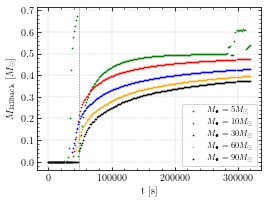

In [14]:
def Mt(t, A, C, alpha):
    return C + A*t**(alpha)
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
colors = ['g','r','b','orange','k']
#labels = ['$N_p=10^6$', '$N_p=5\\times 10^5$','smaller $R_{\\rm acc}$']
labels = ['$M_\\bullet = 5M_\odot$','$M_\\bullet = 10M_\odot$','$M_\\bullet = 30M_\odot$','$M_\\bullet = 60M_\odot$','$M_\\bullet = 90M_\odot$']
plt.figure(figsize=(4,3))
for c, t, d, a, l, strm, core in zip(colors, times, disk_m, acc_m, labels, strm_m, rest_m):
    #plt.scatter(t, a, s=1,label='$M_{\\rm acc}$', color=c,lw=0)
    plt.scatter(t, a+d, s=3,label=l, color=c,lw=0)
    #plt.plot(t, d+a,ls='--',label='$M_{\\rm fall}$', color=c)
    #plt.plot([],[],'.',label=l,color=c)
    
    #if c == 'g':
    #    continue
    #select = ( (d+a) > 1e-4)
    #yh = savgol_filter((d+a)[select], 9, 1)
    
    #popt, pcov = curve_fit(Mt, t[select] , (d+a)[select],p0=[-500000,0.5,-1.5])
    #print(popt)
    #plt.plot(t[select], Mt(t[select],popt[0],popt[1],popt[2]),lw=1,color=c)
#plt.xscale('log')
#plt.yscale('log')
plt.axvline(TIME_DETECT*1600,ls='--',lw=0.5)
plt.legend(ncol=1,fontsize=8)
plt.xlabel('t [s]')
plt.ylabel('$M_{\\rm fallback}$  [$M_\odot$]')
#plt.savefig('sink-bh-iso-mass.png',dpi=192)

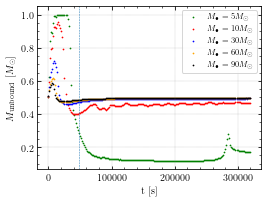

In [268]:
plt.figure(figsize=(4,3))
for c, t, d, a, l, strm, core in zip(colors, times, disk_m, acc_m, labels, strm_m, rest_m):
    #plt.scatter(t, a, s=1,label='$M_{\\rm acc}$', color=c,lw=0)
    plt.scatter(t, core, s=3,label=l, color=c,lw=0)
    #plt.plot(t, d+a,ls='--',label='$M_{\\rm fall}$', color=c)
    #plt.plot([],[],'.',label=l,color=c)
    #if c == 'g':
    #    continue
    #select = ( (d+a) > 1e-4)
    #yh = savgol_filter((d+a)[select], 9, 1)
    
    #popt, pcov = curve_fit(Mt, t[select] , (d+a)[select],p0=[-500000,0.5,-1.5])
    #print(popt)
    #plt.plot(t[select], Mt(t[select],popt[0],popt[1],popt[2]),lw=1,color=c)
#plt.xscale('log')
#plt.yscale('log')
plt.axvline(TIME_DETECT*1600,ls='--',lw=0.5)
plt.legend(ncol=1,fontsize=8)
plt.xlabel('t [s]')
plt.ylabel('$M_{\\rm unbound}$  [$M_\odot$]')
plt.savefig('sink-bh-iso-core-mass.png',dpi=192)

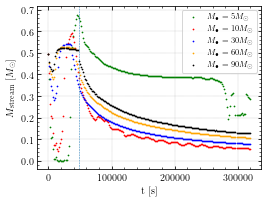

In [272]:
plt.figure(figsize=(4,3))
for c, t, d, a, l, strm, core in zip(colors, times, disk_m, acc_m, labels, strm_m, rest_m):
    #plt.scatter(t, a, s=1,label='$M_{\\rm acc}$', color=c,lw=0)
    plt.scatter(t, strm, s=3,label=l, color=c,lw=0)
    #plt.plot(t, d+a,ls='--',label='$M_{\\rm fall}$', color=c)
    #plt.plot([],[],'.',label=l,color=c)
    #if c == 'g':
    #    continue
    #select = ( (d+a) > 1e-4)
    #yh = savgol_filter((d+a)[select], 9, 1)
    
    #popt, pcov = curve_fit(Mt, t[select] , (d+a)[select],p0=[-500000,0.5,-1.5])
    #print(popt)
    #plt.plot(t[select], Mt(t[select],popt[0],popt[1],popt[2]),lw=1,color=c)
#plt.xscale('log')
#plt.yscale('log')
plt.axvline(TIME_DETECT*1600,ls='--',lw=0.5)
plt.legend(ncol=1,fontsize=8)
plt.xlabel('t [s]')
plt.ylabel('$M_{\\rm stream}$  [$M_\odot$]')
plt.savefig('sink-bh-iso-stream-mass.png',dpi=192)

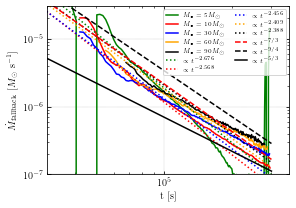

In [18]:


def diff(x, y, step):
    dx = x[1] - x[0]
    #return 0.5*(x[step::] + x[0:-step]), savgol_filter((y[step::] - y[0:-step])/(dx*step), 31, 1)
    return 0.5*(x[step::] + x[0:-step]), (y[step::] - y[0:-step])/(dx*step)
    
def logdiff(x,y,space):
    l = len(x)
    idx = np.unique( (np.exp(np.linspace(0,np.log(l),space))).astype(int))-1
    up = idx[1::]
    lo = idx[0:-1]
    dx = x[up] - x[lo]
    
    return np.exp(0.5 * (np.log(x[up]) + np.log(x[lo]))), (y[up] - y[lo])/dx
    
def powerlaw(x, A, B):
    return B + x * A

lo = 3e4
hi = 3e5
s = 7
steps =[5,5,7,15,25]
plt.figure(figsize=(4,3))
for c, t, d, a, l, step  in zip(colors, times, disk_m, acc_m, labels, steps):
    
    select = ((d+a)>1e-4) & (t < hi) 
    #yh = savgol_filter((d+a)[select], 21, 1)
    dt, df = diff(t[select], (d+a)[select], step)
    smooth_df = savgol_filter(df, 11, 1)
    
    #plt.plot(t[select],yh,color=c)
    plt.plot(dt, df, ls='-',lw=1.5, label=l,color=c)
    #plt.plot(dt, smooth_df, ls='-',lw=1.5, label=l,color=c)
    
    
    #regionx = np.log10(dt)
    #regiony = np.log10(df)
    #popt, pcov = curve_fit(powerlaw, regionx, regiony,p0 = np.asarray([-1,1]))
    #print(popt)
    
    #xx = np.linspace(1e4,4e5,1e4)
    #plt.plot(xx, 10**popt[1]*xx**popt[0], ':',color=c,label='fitting:$\propto$ t$^{ %.2lf}$' % popt[0])
    
time = np.linspace(lo, hi)
power1 = 1e6*time**(-7.0/3.0)
power2 = 6e5*time**(-9.0/4)
power3 = 1.5e2*time**(-5.0/3)

power4 = 4.5e7*time**(-2.676)
power5 = 0.8e7*time**(-2.568)
power6 = 2.5e6*time**(-2.456)
power7 = 2e6*time**(-2.409)
power8 = 1.8e6*time**(-2.388)

plt.plot(time, power4, color='g',ls=':', label='$\propto t^{-2.676}$')
plt.plot(time, power5, color='r',ls=':', label='$\propto t^{-2.568}$')
plt.plot(time, power6, color='b',ls=':', label='$\propto t^{-2.456}$')
plt.plot(time, power7, color='orange',ls=':', label='$\propto t^{-2.409}$')
plt.plot(time, power8, color='k',ls=':', label='$\propto t^{-2.388}$')


plt.plot(time, power1, color='r',ls='--', label='$\propto t^{-7/3}$')
plt.plot(time, power2, color='k',ls='--', label='$\propto t^{-9/4}$')
plt.plot(time, power3, color='k',ls='-', label='$\propto t^{-5/3}$')

plt.xscale('log')
plt.yscale('log')
plt.legend(ncol=2,fontsize=6)
plt.xlabel('t [s]')
plt.xlim(lo, 1.2*hi)
plt.ylim([1e-7,3e-5])
plt.tight_layout()
plt.ylabel('$\dot{M}_{\\rm fallback}$  [$M_\odot$ s$^{-1}$]')
plt.savefig('iso-mass_sink_m_dot.png',dpi=192,bbox_inches = "tight")

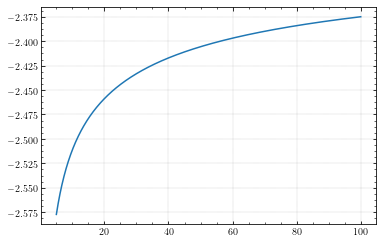

In [88]:
mcore = 0.5
mb = np.linspace(5,100,1000)
u = mcore/mb

n = -2.257-0.69*u**(1.0/3)
plt.plot(mb,n)

In [ ]:
import pandas as pd
def load_sink_ev(name):
    data = np.loadtxt(name)
    t = data[:,0] * 1593.7103639
    x = data[:,1]
    y = data[:,2]
    z = data[:,3]
    m = data[:,4]
    vx = data[:,5]
    vy = data[:,6]
    vz = data[:,7]
    sx = data[:,8]
    sy = data[:,9]
    sz = data[:,10]
    macc=data[:,11]
    return {'t':t, 'x':x,'y':y,'z':z,'vx':vx,'vy':vy,'vz':vz,'m':m,'sx':sx,'sy':sy,'sz':sz,'macc':macc}
    
def load_ev(name):
    data = np.loadtxt(name)

    t = data[:,0] * 1593.7103639
    ek = data[:,1]
    etherm = data[:,2]
    epot =data[:,4]
    etot =data[:,5]
    eacc =data[:,19]
    totmom=data[:,6]
    angtot=data[:,7]
    totentrop=data[:,11]
    cmx = data[:,14]
    cmy = data[:,15]
    cmz = data[:,16]
   # accm = data[:,20]
    return {'t':t, 'ek':ek, 'eth':etherm,'totmom':totmom ,'epot':epot, 'etot':etot, 'totentrop':totentrop,'eacc':eacc,'cmx':cmx,'cmy':cmy,'cmz':cmz}
    
#rp1 = load_ev('../code/low_N/rp1/tde.ev')
#rp09 = load_ev('../code/low_N/rp09/tde.ev')
#rp06 = load_ev('../code/low_N/rp06/tde.ev')
#rph = load_ev('../code/heating-cluster/tde.ev')
#plt.plot(t, etherm)

In [ ]:
c01=load_ev('../code/local-test/c_01/tde01.ev')
c03=load_ev('../code/local-test/c_03/tde01.ev')
c06=load_ev('../code/local-test/c_06/tde01.ev')
c09=load_ev('../code/local-test/c_09/tde01.ev')
c_ev=[c01,c03,c06,c09]
c_labels=['C=0.1','C=0.3','C=0.6','C=0.9']
draw_ev(c_ev,c_labels,'E-err-C.pdf')

In [ ]:
f05=load_ev('../code/local-test/f_05/tde01.ev')
f0125=load_ev('../code/local-test/f_0125/tde01.ev')
f_ev=[f0125,c03,f05]
f_labels=['Cf=0.125','Cf=0.25','Cf=0.5']
draw_ev(f_ev,f_labels,'E-err-Cf.pdf')

In [ ]:
v0001=load_ev('../code/local-test/v_0001/tde01.ev')
v0005=load_ev('../code/local-test/v_0005/tde01.ev')
v002=load_ev('../code/local-test/v_002/tde01.ev')
v_ev=[v0001,v0005,c03,v002]
v_labels=['$tol_v=0.1$%','$tol_v=0.5$%','$tol_v=1$%','$tol_v=2$%']
draw_ev(v_ev,v_labels,'E-err-v.pdf')

In [ ]:
def draw_ev(ev,labels,names):
    for e, l in zip(ev,labels):
        plt.plot(e['t'],np.abs((e['etot']-e['etot'][0])/e['etot'][0]),label=l,lw=1)
    plt.legend()
    plt.yscale('log')
    plt.xlabel('time [s]')
    plt.ylabel('$|E_{\\rm tot}-E_0|/|E_0|$')
    #plt.xscale('log')
    plt.savefig(names,dpi=192)

In [ ]:
#ev = [rp1, rp09, rp06, rph]
labels = ['rp=1rt', 'rp=09rt', 'rp=06rt', 'rp=1rt with heating']

In [ ]:
larger =load_ev('../code/heating-larger/tde01.ev')
small =load_ev('../code/heating-cluster/tde.ev')
labels = ['$R_{acc}=100R_s$', '$R_{acc}=1000R_s$']
ev = [small, larger]

In [ ]:
without =load_ev('../code/new-without-heating/tde.ev')
noacc =load_ev('../code/no-acc/tde.ev')
labels = ['without heating', '$No accretion$']
ev = [without, noacc]

In [ ]:
rad =load_ev('../code/sinkrad/tde.ev')
ada =load_ev('../code/sinktde/tde.ev')
#rs =load_ev('../code/1m-N-rad-1e3/tde.ev')
labels = ['radiative', 'adiabatic']
ev = [rad, ada]

In [ ]:
labels =['test']
ev = [load_ev('../code/local-test/tde01.ev')]

In [ ]:
sinkev=load_sink_ev('../code/sinktde/tdeSink0001N01.ev')
sinkrad=load_sink_ev('../code/sinkrad/tdeSink0001N01.ev')

In [ ]:
plt.plot(sinkev['t'],sinkev['macc'])
plt.plot(sinkrad['t'],sinkrad['macc'],ls='--')
plt.xscale('log')

In [ ]:
def draw_eacc(evcom,evu,evp,evk):
    plt.figure()
    plt.plot(evcom['t'],evcom['eacc'],label='Correct $K_B$')
    plt.plot(evu['t'],evu['eacc'],label='$u_A$')
    plt.plot(evp['t'],evp['eacc'],label='$P_{A-B}+P_{A-C}$')
    plt.plot(evk['t'],evk['eacc'],label='$K_A$')
    #plt.plot(evk['t'],evk['eacc']+evp['eacc'],label='$K_A$')
    
    plt.legend()
    plt.xlabel('t [sec]')
    plt.ylabel('$E_{acc}$')
    plt.xscale('log')
    #plt.yscale('symlog',linthreshy=0.1)
    plt.savefig('E_acc1.png')
#evcom = load_ev('../code/local-test/tde13.ev')
#evu = load_ev('../code/local-test/tde14.ev')
#evp = load_ev('../code/local-test/tde15.ev')
#evk = load_ev('../code/local-test/tde16.ev')
evall = load_ev('../code/local-test/tde12.ev')
draw_eacc(evcom,evu,evp,evk)

In [ ]:
def draw_energy(ev):
    fig = plt.figure(figsize=(8,6))
    
    axs = [ fig.add_subplot(2,2,i+1) for i in range(4)]
    
    for e, l in zip(ev,labels):
        #print(e['cmx'])
        axs[0].plot(e['t'],e['ek'],label=l,lw=1)
        axs[1].plot(e['t'],e['epot'],label=l,lw=1)
        axs[2].plot(e['t'],e['cmx'],label=l,lw=1)
        #axs[3].plot(e['t'],np.abs((e['etot']-e['etot'][0])/e['etot'][0]),label=l,lw=1)
        axs[3].plot(e['t'],e['etot']-e['eacc'],label=l,lw=1)
        
    for ax in axs:
        ax.set_xlabel('time [s]')
        ax.set_xscale('log')
        #ax.set_xlim([0,3e4])
        #ax.set_yscale('symlog')
        ax.legend(frameon=False)
        
    ylabel = ['$E_k$', '$E_p$', '$E_{\\rm therm}$', '$|E_{\\rm tot}-E_0|/|E_0|$']
    
    for ax, l in zip(axs, ylabel):
        ax.set_ylabel(l)
    plt.tight_layout()
    
    #plt.savefig('energies.png',dpi=96)
draw_energy(ev)

In [ ]:
def draw_com(ev):
    fig = plt.figure(figsize=(8,6))
    
    axs = [ fig.add_subplot(2,2,i+1) for i in range(4)]
    
    for e, l in zip(ev,labels):
        axs[0].plot(e['t'],e['cmx'],label=l,lw=1)
        axs[1].plot(e['t'],e['cmy'],label=l,lw=1)
        axs[2].plot(e['t'],e['cmy'],label=l,lw=1)
        axs[3].plot(e['t'],0.5*e['totmom']**2/11,label=l,lw=1)
        
    for ax in axs:
        ax.set_xlabel('time [s]')
        ax.set_xscale('log')
        #ax.set_xlim([0,3e4])
        #ax.set_yscale('symlog')
        ax.legend(frameon=False)
        
    ylabel = ['$CoM_x$', '$CoM_y$', '$CoM_z$', '$K_{\\rm CoM}$']
    
    for ax, l in zip(axs, ylabel):
        ax.set_ylabel(l)
    plt.tight_layout()
    
    plt.savefig('Kcom.png',dpi=96)
draw_com([evall])

In [ ]:
m1 =9.3817431278731586E-005 
vx = 1.6405609526404483    
vy = 1.8969900060669009   
vz = 2.6386761492043793

M = 10.031804109203215
vvx = 4.1458630411563432E-002 
vvy = 2.2862830052876391E-002
vvz = -1.2023210372216643E-005

pm = 10.031897926634493
px = 4.1473585076505254E-002
py = 2.2880356726176814E-002  
pz = 1.2653570441538377E-005

print (m1+M-pm)

In [ ]:
def draw_entropy(ev):
    for e, l in zip(ev,labels):
        plt.plot(e['t'],e['totentrop'],label=l,lw=11)
    plt.legend()
    plt.xlabel('time [s]')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('S_tot')
draw_entropy(ev)

In [13]:
import scipy.stats as st
import matplotlib.mlab as ml
    
def np_array2dic(array, keys, units):
    dic = {}
    for i, key in enumerate(keys):
        dic[key] = array[:,i] * units[i]
        
    return dic 

def load_ascii(fname):
    dic = {}
    data = np.loadtxt(fname)
    Rs = 1#6.955e10
    #keys = ['x','y','z','pmass',
    #        'h','den','vx','vy','vz','u',
    #        'T','P','alpha','div','pot', 'type']
    
    #units = [9.9992818E-01*Rs,   9.9992818E-01*Rs,   9.9992818E-01*Rs,   1.9890999E+33,
    #         9.9992818E-01,   5.9009576E+00,   4.3668536E+07,   4.3668536E+07,   4.3668536E+07,   1.9069412E+15,
    #         1, 1.1252779E+16, 1.0000000E+00, 6.2746659E-04,   1.9069412E+15,1]
    
    keys = ['x','y','z','pmass',
            'h','den','vx','vy','vz','u',
            'T','alpha','div','pot','type']
    
    units = [9.9992818E-01*Rs,   9.9992818E-01*Rs,   9.9992818E-01*Rs,   1.9890999E+33,
             9.9992818E-01,   5.9009576E+00,   4.3668536E+07,   4.3668536E+07,   4.3668536E+07,   1.9069412E+15,
             1, 1.0000000E+00 ,1.9069412E+15,1.9069412E+15,1]
    
    #keys = ['x','y','z','pmass',
    #        'h','den','vx','vy','vz','u',
    #        'alpha','div','poten','type']
    
    #units = [9.9992818E-01*Rs,   9.9992818E-01*Rs,   9.9992818E-01*Rs,   1.9890999E+33,
    #         9.9992818E-01,   5.9009576E+00,   4.3668536E+07,   4.3668536E+07,   4.3668536E+07,   1.9069412E+15,
    #         1.0000000E+00,   6.2746659E-04,   1.9069412E+15,1]
    dic = np_array2dic(data, keys, units )
    
    calc_TP(dic)
    return dic

def calc_TP(dump):
    mH = 1.6733e-24
    mean_mole = 2.381 
    kb = 1.38064852e-16
    Gamma = 5.0/3
    #T = dump['T']
    T = dump['u']*(Gamma - 1)* mean_mole * mH/kb
    dump['T'] = T
    dump['Tem']= T
    
    P_gas = dump['den']*kb*T/(mean_mole*mH)
    
    sigma = 5.6704e-5
    c = 2.9979e10
    
    P_rad = 4*sigma/(3*c)*T**4
    
    dump['P_gas']=P_gas
    
    dump['P_rad']=P_rad
    
    dump['n']=dump['den']/(mean_mole*mH)
    
    dump['calc_u'] =  (kb*T*(Gamma - 1)/(mean_mole*mH) + 4*sigma/(dump['den']*c)*T**4)#/1.9069412E+15 
    
    print(dump['calc_u'])
    a = 4*sigma/(c)
    b = kb*(Gamma - 1)/(mean_mole*mH)
    
    e = 1.9069412E+15
    #print(a/e,b/e)

def calc_Omega(dump, Mb):
    x = dump['x']
    y = dump['y']
    z = dump['z']
    
    r = np.sqrt(x**2 + y**2 + z**2)
    G  =6.67e-8
    Ms = 1.98e33
    dump['Omega'] = np.sqrt(G * Mb*Ms / R**3)
    
def draw_prop(fname, dump, Mb, render, render_name, cmap=cm.hot, r0=0):
    fig =plt.figure(figsize=(8,6))
    axis = [fig.add_subplot(2,2,i+1) for i in range(3)]
    Rs = Mb*3.0/696342
    
    x = dump['x']
    y = dump['y']
    z = dump['z']
    x0 =x[-1]
    y0 =y[-1]
    z0 =z[-1] 
    r = np.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)
    T = dump[render]
    tp = dump['type']
    
    b = 55
    region = (-b < z) & (z < b) &  (-b < x) & (x < b) & (-b < y) & (y < b) & (tp == 1) & (r>r0)
    
    x = x[region]
    y = y[region]
    z = z[region]
    r = (r[region])
    T= np.log10(T[region])
    
    coords = [(x,y), (y, z), (x,z)]
    labels = [('x [$R_\odot$]', 'y [$R_\odot$]'), ('y [$R_\odot$]', 'z [$R_\odot$]'), ('x [$R_\odot$]', 'z [$R_\odot$]')]

    for ax, coord, l in zip(axis, coords, labels):
        im = ax.tricontourf(coord[0], coord[1], T, 100, cmap=cmap)
        ax.set_xlabel(l[0])
        ax.set_ylabel(l[1])
        plt.gca().set_aspect('equal', adjustable='box')
        
        cbar = fig.colorbar(im,ax=ax)
        cbar.set_label('$\log_{10}('+render_name+')$')
    
    ax = fig.add_subplot(2,2,4)
    #ax.scatter(r, T,s=0.1,lw=0,color='red')
    handler = ax.hist2d(r, T,bins=200, normed=True,cmap=cmap)
    ax.set_xlabel('r [$R_\odot$]')
    ax.set_ylabel('$\log_{10}('+render_name+')$')
    cbar = fig.colorbar(handler[3],ax=ax)
    cbar.set_label('KDE')

    plt.tight_layout()
    
    plt.savefig(fname,dpi=96)
    
def get_E_tot(dump, Mb):
    x = dump['x']
    y = dump['y']
    z = dump['z']
    h = dump['h']
    m = dump['pmass'][0]
    #den = dump['den']
    tp = dump['type']
    #T = dump['Tem']
    u = m*dump['u']
    
    vx = dump['vx']
    vy = dump['vy']
    vz = dump['vz']
    
    r = np.sqrt(x**2 + y**2 + z**2)
    
    sink_p = tp == 3
    disk_p = tp == 1
    acced_p = tp == 9 # 0.4254 #tp == 9
    
    Ek = m*0.5*(vx**2+vy**2+vz**2)
    #G = 6.674e-8
    #Mb *= 1.9890999e33 
    #Ep = -m*G*Mb/r
    Ep=m*dump['pot']
   # Etot = m*(Ek+Ep+u) #[disk_p].sum()+Ep[disk_p].sum()#+u.sum()
    
    Ek = Ek[disk_p].sum() + Ek[sink_p].sum()
    u = m*u[disk_p]
    
    return Ek, Ep[acced_p].sum(), u.sum()
    
    #return m*acced_p.sum(), Ek[disk_p].sum(), Ep[disk_p].sum(), u[disk_p].sum(),Ek[acced_p].sum(), Ep[acced_p].sum(), u[acced_p].sum()
    
    
def get_E_t():
    idxs = np.linspace(1,19,19)
    
    Ekd = []
    Epd = []
    Eud = []
    Eka = []
    Epa = []
    Eua = []
    accm =[]
    
    for idx in idxs:
        name = '../code/sinktde/tde_%05d'% idx
        name += '.ascii'
        print(name)
        dump = load_ascii(name)
        acm, kd,pd,ud,ka,pa,ua = get_E_tot(dump,10)
        accm.append(acm)
        Ekd.append(kd)
        Epd.append(pd)
        Eud.append(ud)
        Eka.append(ka)
        Epa.append(pa)
        Eua.append(ua)
        
    return np.array(accm), np.array(Ekd), np.array(Epd), np.array(Eud), np.array(Eka), np.array(Epa), np.array(Eua)
def get_Etot_t():
    idxs = np.linspace(1,19,19)
    
    Ek = []
    Ep = []
    Eu = []

    
    for idx in idxs:
        name = '../code/sinktde/tde_%05d'% idx
        name += '.ascii'
        print(name)
        dump = load_ascii(name)
        ek, ep, eu = get_E_tot(dump,10)
        
        Ek.append(ek)
        Ep.append(ep)
        Eu.append(eu)
    return np.array(Ek), np.array(Ep), np.array(Eu)

#Ek,Ep,Eu = get_Etot_t()

In [ ]:
t = np.linspace(0,100,101)*4.4269732E-01*3600
t = t[0:len(Ekd)]

fig=plt.figure(figsize=(9,10.5))
ax1 = fig.add_subplot(3,2,1)
ax1.plot(t,Ekd,label='disk particle',ls='--')
ax1.plot(t,Eka,label='accreted particle',ls='--')
ax1.plot(t,Eka+Ekd,label='tot')
ax1.legend()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('t [sec]')
ax1.set_ylabel('Ek [erg]')
ax1.set_ylim([1e46,1e58])

ax2 = fig.add_subplot(3,2,2)
ax2.plot(t,Epd,label='disk particle',ls='--')
ax2.plot(t,Epa,label='accreted particle',ls='--')
ax2.plot(t,Epa+Epd,label='tot')
ax2.legend()
ax2.set_xscale('log')
ax2.set_yscale('symlog')
ax2.set_xlabel('t [sec]')
ax2.set_ylabel('Ep [erg]')
ax2.set_ylim([-1e46,-1e50])

ax3 = fig.add_subplot(3,2,3)
ax3.plot(t,Epd+Ekd,label='disk particle',ls='--')
ax3.plot(t,Epa+Eka,label='accreted particle',ls='--')
ax3.plot(t,Epa+Epd+Eka+Ekd,label='tot')
ax3.legend()
ax3.set_xscale('log')
ax3.set_yscale('symlog',linthreshy=1e47)
ax3.set_xlabel('t [sec]')
ax3.set_ylabel('Emech [erg]')
#ax3.set_ylim([-1e48,-1e52])

ax3 = fig.add_subplot(3,2,4)
ax3.plot(t,Eud,label='disk particle',ls='--')
ax3.plot(t,Eua,label='accreted particle',ls='--')
ax3.plot(t,Eua+Eud,label='tot')
ax3.legend()
ax3.set_xscale('log')
ax3.set_yscale('symlog',linthreshy=1e47)
ax3.set_xlabel('t [sec]')
ax3.set_ylabel('U [erg]')

ax4 = fig.add_subplot(3,2,5)
ax4.plot(t,Eud+Ekd+Epd,label='disk particle',ls='--')
ax4.plot(t,Eua+Eka+Epa,label='accreted particle',ls='--')

ax4.plot(t,Eud+Ekd+Epd+Eua+Eka+Epa,label='tot')
ax4.legend()
ax4.set_xscale('log')
ax4.set_yscale('symlog',linthreshy=5e48)
ax4.set_xlabel('t [sec]')
ax4.set_ylabel('Etot [erg]')
plt.tight_layout()
#plt.savefig('radiation-energy-check.png',dpi=192)
#plt.xscale('log')
#plt.yscale('symlog')

In [ ]:
def check_dump(dump):
    x = dump['x']
    y = dump['y']
    z = dump['z']
    h = dump['h']
    m = dump['pmass']
    #den = dump['den']
    tp = dump['type']
    #T = dump['Tem']
    u = dump['u']
    
    vx = dump['vx']
    vy = dump['vy']
    vz = dump['vz']
    
    r = np.sqrt(x**2 + y**2 + z**2)
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    G = 6.674e-8
    Mb =10* 1.9890999e33 
    Ep = -G*Mb/r
    
    #print(v[h<0][0])
    plt.scatter(r,u,s=1)
    #plt.hist(v,50)
    plt.xscale('log')
    plt.yscale('symlog',linthreshy=1e9)
    plt.xlabel('r [Rs]')
    plt.ylabel('u [erg/g]')
    #plt.savefig('u.png')

dump = load_ascii('../code/unsoft/1e4/tde_00099.ascii')
check_dump(dump)

In [ ]:
dump4 = load_ascii("../code/unsoft/1e4/tde_00001.ascii")
dump3 = load_ascii("../code/unsoft/1e3/tde_00100.ascii")

In [ ]:
draw_prop('rho_soft_1e4.png',dump,10,'den', '\\rho/{\\rm g\cdot cm^{-3}}',cm.plasma, 0.425*10)

In [ ]:
def draw_hydro(dumps):
    
    fig= plt.figure()
    labels=['$R_{\\rm acc}=10^3 R_s$', '$R_{\\rm acc}=10^4 R_s$']
    for dump,l in zip(dumps,labels):
        u = dump['u']
        calc_u = dump['calc_u'] #+ dump['P_rad']
    
        err = np.abs(np.array(abs(calc_u - u)/u))
    
        p1 = dump['type']==1
    
        pacc = dump['type']==9
    
    #print(np.array(u)/np.array(calc_u))
        plt.hist((u[p1]),30,histtype='step',label=l,ls='--',color='b')
        plt.hist((u[pacc]),30,histtype='step',label=l,ls='--',color='r')
    #plt.hist(err[pacc],30,label='accreted particles',histtype='step')
    plt.yscale('log')
    plt.legend()
    plt.xlabel('$\log_{10}(|u_c-u|/u)$')
    #plt.savefig('thermal-check.png')
draw_hydro([dump3])

In [99]:
def draw_u_err(dump):
    u = dump['u']
    u_calc = dump['calc_u']
    
    du = (u_calc - u)
    
    rtol = np.abs(du/u)*100
    
    active = dump['h']>0
    
    T = dump['T']
    
    #print(u[active], u_calc[active])
    plt.hist(rtol[active][0:-2],bins=80,density=True,color='yellowgreen',alpha=0.9)
    plt.xlabel('$|u_c-u|/|u|$   [\%]')
    plt.ylabel('PDF')
    plt.grid(True)
    plt.savefig('u-check.pdf',dpi=192,bbox_inches = 'tight')
    
def draw_u_err_r(dump):
    u = dump['u']
    u_calc = dump['calc_u']
    
    du = (u_calc - u)
    
    rtol = np.abs(du/u)*100
    
    active = dump['h']>0
    
    T = dump['T']
    
    x = dump['x']
    y = dump['y']
    z = dump['z']
    x0 =x[-1]
    y0 =y[-1]
    z0 =z[-1] 
    r = np.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)
    
    #print(u[active], u_calc[active])
    plt.scatter(rtol[active][0:-2],r[active][0:-2],s=0.01,lw=0,color='orange')
    plt.xlabel('$|u_c-u|/|u|$   [\%]')
    plt.ylabel('PDF')
    plt.grid(True)
   # plt.savefig('u-check.pdf',dpi=192,bbox_inches = 'tight')

In [14]:
dump = load_ascii("../code/sink/0.5M/10000/tde_00500.ascii")
suffix = '_50_std_05M_1e4Rs'

[4.07147554e+08 1.54056290e+09 5.44070559e+08 ... 7.45816735e+17
 1.02214622e+31            nan]


/home/yihanw/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in divide


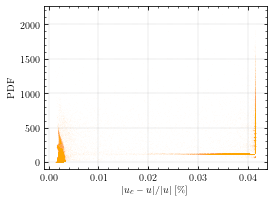

In [100]:
draw_u_err_r(dump)

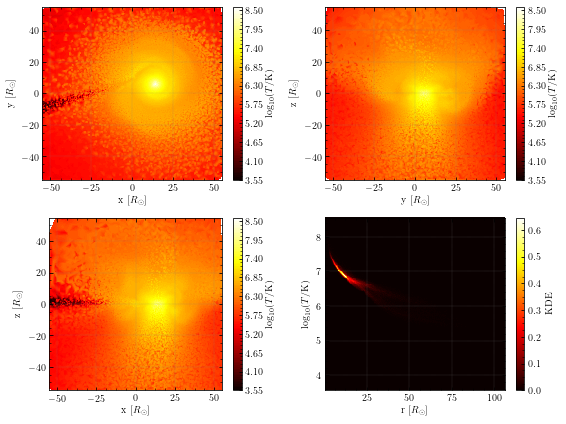

In [15]:
draw_prop('T'+suffix+'.png',dump,10,'Tem', 'T/{\\rm K}')

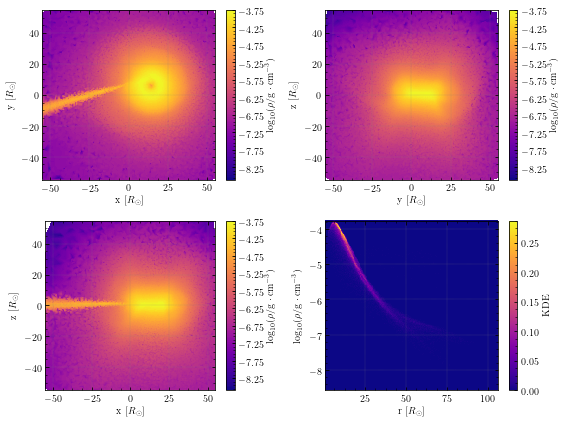

In [16]:
draw_prop('rho'+suffix+'.png',dump,10,'den', '\\rho/{\\rm g\cdot cm^{-3}}',cm.plasma)

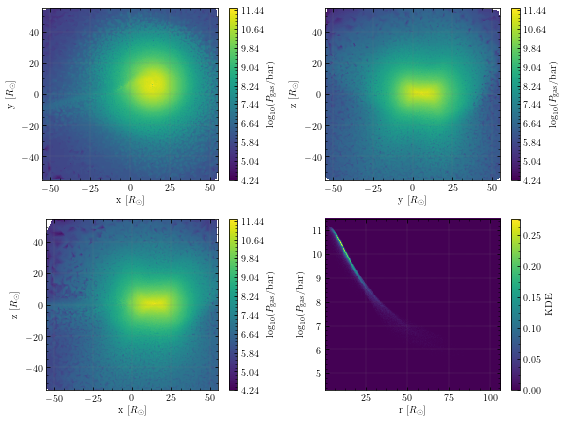

In [17]:
draw_prop('P_gas'+suffix+'.png',dump,10,'P_gas', 'P_{\\rm gas}/{\\rm bar}',cm.viridis)

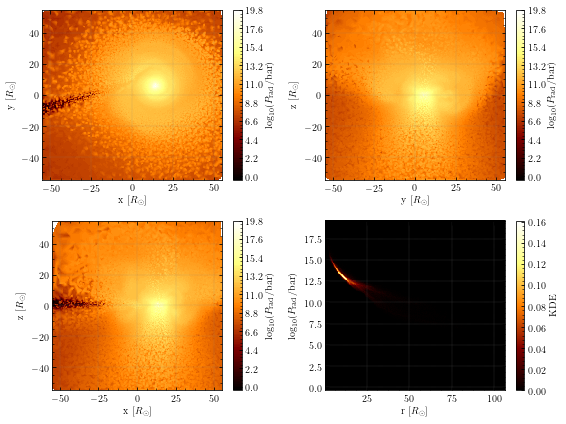

In [18]:
draw_prop('P_rad'+suffix+'.png',dump,10,'P_rad', 'P_{\\rm rad}/{\\rm bar}',cm.afmhot)

In [19]:
dump_rad = load_ascii("../code/sink/0.5M/10000_rad/tde_00500.ascii")
dump = load_ascii("../code/sink/0.5M/10000/tde_00500.ascii")

/home/yihanw/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in divide


[3.97309881e+08 6.13562943e+08 7.00859481e+07 ... 1.30547571e+26
 3.55742681e+18            nan]
[4.07147554e+08 1.54056290e+09 5.44070559e+08 ... 7.45816735e+17
 1.02214622e+31            nan]


In [37]:
from scipy.interpolate import RegularGridInterpolator as rgi
import scipy

def calc_ionized_f(n, T):
    kb = 1.38064852e-16
    ev = 1.6e-12
    h = 6.62e-27
    me = 9.1e-28
    
    lamb = np.sqrt(h*h/(2*np.pi*me*kb*T)) 
    
    C = np.exp(-13.6*ev/(kb*T))/lamb**3
    
    #print(np.exp(-13.54*ev/(kb*T)))
    #f = 0.5*(np.sqrt(C*C + 4*C) - C)
    ne = np.sqrt(C*n)
    ne = min(ne, n)
    return ne
    
def calc_den_f(dump):
    x = dump['x']
    y = dump['y']
    z = dump['z']
    rho = dump['den']
    f = scipy.interpolate.NearestNDInterpolator((x,y,z),rho)
    return f

def gen_integral_path(dump,phi,theta,rmax, num):
    x = dump['x']
    y = dump['y']
    z = dump['z']
    x0 = x[-1]
    y0 = y[-1]
    z0 = z[-1]
    
    r = np.linspace(0.425,rmax,num)

    xx = r*np.sin(theta)*np.cos(phi) + x0
    yy = r*np.sin(theta)*np.sin(phi) + y0
    zz = r*np.cos(theta) + z0
    
    return xx, yy, zz, r
    
def calc_optical_depth(xx, yy, zz, r, f):
    tau = np.zeros(r.shape)
    dr = abs(r[0]-r[1])
    mh = 1.66e-24
    sigma_k=6.65e-25
    Rs =6.955e10
    coef = sigma_k/mh*Rs
    print(coef,f(xx,yy,zz),dr)
    for i in range(len(tau)):
        t = f(xx[-i::],yy[-i::],zz[-i::]).sum()*dr
        tau[-i] = t
    return tau*coef, r

In [46]:
def optical_depth(dump, phi, theta):
    xx, yy, zz, r = gen_integral_path(dump, phi , theta, 100, 5000)
    f = calc_den_f(dump)
    tau, r  = calc_optical_depth(xx,yy,zz,r,f)
    
    return r, tau

In [47]:
phis = np.linspace(0,1.5*np.pi,4)
thetas = np.linspace(0,np.pi,5)

In [63]:
odepth = [optical_depth(dump, phi, np.pi/2) for phi in phis]
odepth_rad = [optical_depth(dump_rad, phi, np.pi/2) for phi in phis]

(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.70918875e-09, 5.70918875e-09, 5.70918875e-09]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.22389312e-08, 2.22389312e-08, 2.22389312e-08]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.39509088e-08, 1.39509088e-08, 1.39509088e-08]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.99647812e-08, 1.99647812e-08, 1.99647812e-08]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.82668957e-08, 3.82668957e-08, 3.82668957e-08]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       4.66564057e-08, 4.66564057e-08, 4.66564057e-08]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+

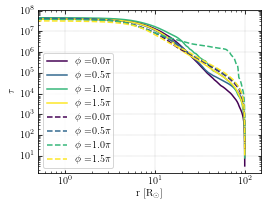

In [64]:
colors = plt.cm.viridis(np.linspace(0,1,len(phis)))
plt.figure(figsize=(4,3))
for d, phi, c in zip(odepth, phis, colors):
    plt.plot(d[0],d[1],label='$\phi=$'+str(phi/np.pi)+'$\pi$',ls='-',color=c)
for d, phi, c in zip(odepth_rad, phis, colors):
    plt.plot(d[0],d[1],label='$\phi=$'+str(phi/np.pi)+'$\pi$',ls='--',color=c)
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.5,151])
plt.legend()
plt.xlabel('r [R$_\odot$]')
plt.ylabel('$\\tau$')
plt.savefig('optical-depth-phi.png',dpi=192,bbox_inches = 'tight')

In [56]:
odepth = [optical_depth(dump, 0, theta) for theta in thetas]
odepth_rad = [optical_depth(dump_rad, 0, theta) for theta in thetas]


(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       3.12742161e-09, 3.12742161e-09, 3.12742161e-09]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.10540484e-09, 5.10540484e-09, 5.10540484e-09]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.70918875e-09, 5.70918875e-09, 5.70918875e-09]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       6.47444098e-08, 6.47444098e-08, 6.47444098e-08]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       6.97361597e-08, 6.97361597e-08, 6.97361597e-08]), 0.020004000800160033)
(27861897590.361446, array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       4.38137516e-08, 4.38137516e-08, 4.38137516e-08]), 0.020004000800160033)
(27861897590.361446, array([0.0000000e+0

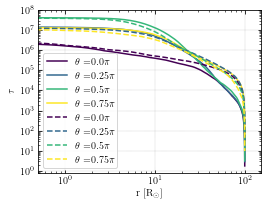

In [62]:
plt.figure(figsize=(4,3))
for d, theta, c in zip(odepth, thetas,colors):
    plt.plot(d[0],d[1],label='$\\theta=$'+str(theta/np.pi)+'$\pi$',ls='-',c=c)
    
for d, theta,c in zip(odepth_rad, thetas,colors):
    plt.plot(d[0],d[1],label='$\\theta=$'+str(theta/np.pi)+'$\pi$',ls='--',c=c)
plt.legend()
plt.xlabel('r [R$_\odot$]')
plt.ylabel('$\\tau$')
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.5,151])
plt.savefig('optical-depth-theta.png',dpi=192,bbox_inches = 'tight')

[array([-2.48699075]), array([-2.56785435]), array([-2.45597418]), array([-2.40918651]), array([-2.3875939])]


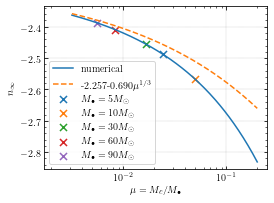

In [262]:

from scipy.optimize import fsolve
def xi(mu):
    return lambda x: x**3*(1-x)**2-(1-x)**2+mu*x**2

def n(xi,mu):
    omega = 0.25*(-1+(9+16/xi**3+16*mu/(1-xi)**3)**0.5)
    return -1-2.0/3*omega

mu = 10**np.linspace(-2.5,-0.7,200)

mu_bh = [0.12/5,0.5/10,0.5/30,0.5/60,0.5/90]
labels = ['$M_\\bullet=5M_\odot$','$M_\\bullet=10M_\odot$','$M_\\bullet=30M_\odot$','$M_\\bullet=60M_\odot$','$M_\\bullet=90M_\odot$']
mu_bh_lo = [0.5/(5+0.88),0.5/(10+0.5),0.5/(30+0.5),0.5/(60+0.5),0.5/(90+0.5)]
n_bh = []
n_bh_lo =[]

ns = []
for mui in mu:
    x0 = 1
    x =  fsolve(xi(mui), x0)
    ns.append(n(x,mui))
    
for mui in mu_bh:
    x0 = 1
    x =  fsolve(xi(mui), x0)
    n_bh.append(n(x,mui))
    
for mui in mu_bh_lo:
    x0 = 1
    x =  fsolve(xi(mui), x0)
    n_bh_lo.append(n(x,mui))

nerr = np.array(n_bh) - np.array(n_bh_lo)

plt.figure(figsize=(4,3))
plt.plot(mu,ns,label='numerical')
plt.plot(mu,-2.257-0.69*(mu)**(1.0/3),ls='--',label='-2.257-0.690$\mu^{1/3}$')





print(n_bh)
for m, n,l in zip(mu_bh, n_bh,labels):
    plt.scatter(m,n,s=50,marker='x',label=l)

plt.xscale('log')
plt.legend()
plt.xlabel('$\mu=M_c/M_\\bullet$')
plt.ylabel('$n_\infty$')
plt.savefig('n_infty.pdf',dpi=192,bbox='tight')